# Pretrained model weights are not frozen it changes during training
 unless  explicitly set them to requires_grad=False
 
 #Freeze the pretrained layers
        for param in self.convnet.parameters():
            param.requires_grad = False

In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
from helper import set_seed

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        #we don't need to resize into 96*96 because we are doing that in below contrastive transform (self.resize_transform = transforms.resize((96,96)))
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        return image1, image2

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    #transforms.Normalize(mean=mean, std=std) #Dataset specific normalisation
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #When you are using pre-trained models that expect inputs normalized with specific values.
])

# Create the dataset
image_dir = r"../../tiff_experiment_unsupervised_data/combined"

dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

Dataset specific normalisation: Normalise using computed mean and std of our special dataset instead of just mean = 0.5,std =0.5

def compute_mean_std(dataloader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for images, _ in dataloader:
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
        images = images.view(batch_samples, images.size(1), -1)  # reshape to (N, C, H*W)
        mean += images.mean(2).mean(0)  # calculate mean per channel
        std += images.std(2).std(0)  # calculate std per channel
        nb_samples += batch_samples
    
    mean /= nb_samples
    std /= nb_samples
    return mean, std


mean,std = compute_mean_std(train_loader)
print(mean)
print(std)

Batch 0:
  Image1: torch.Size([16, 3, 96, 96])
  Image2: torch.Size([16, 3, 96, 96])


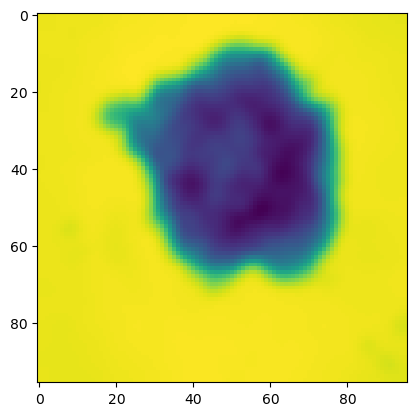

In [4]:
for i, (image1, image2) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    plt.imshow(image1[0,0])
    break

In [5]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


In [6]:
# Define the SimCLR model class (plain PyTorch version)
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):
        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)

        '''if concanated image have dfifferent format use below one'''
        # Create target tensor
        #target = torch.arange(cos_sim.shape[0], device=cos_sim.device)
        #target[0::2] += 1
        #target[1::2] -= 1
       #index = target.reshape(cos_sim.shape[0], 1).long()

        # Prepare ground_truth_labels
        #ground_truth_labels = torch.zeros(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        #src = torch.ones(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        #ground_truth_labels = torch.scatter(ground_truth_labels, 1, index, src)
        #pos_mask = ground_truth_labels.bool()
        # InfoNCE loss
        cos_sim = cos_sim / self.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        return nll

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        # Wrap the train_loader with tqdm
        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2 = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
            self.optimizer.zero_grad()
            loss = self.info_nce_loss(imgs1, imgs2, device)
            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()
            total_loss += loss.item()

            # Compute accuracies
            feats = self.forward(torch.cat((imgs1, imgs2), dim=0))
            target = torch.cat((torch.arange(imgs1.size(0)), torch.arange(imgs2.size(0)))).to(device)
            top1_acc, top5_acc = accuracy(feats, target, topk=(1, 5))
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        return avg_loss, avg_top1_acc, avg_top5_acc

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        # Wrap the val_loader with tqdm
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2 = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
                loss = self.info_nce_loss(imgs1, imgs2, device)
                total_loss += loss.item()

                # Compute accuracies
                feats = self.forward(torch.cat((imgs1, imgs2), dim=0))
                target = torch.cat((torch.arange(imgs1.size(0)), torch.arange(imgs2.size(0)))).to(device)
                top1_acc, top5_acc = accuracy(feats, target, topk=(1, 5))
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        return avg_loss, avg_top1_acc, avg_top5_acc

In [7]:
def plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Top-1 accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_top1_accs, 'bo-', label='Training Top-1 Accuracy')
    plt.plot(epochs, val_top1_accs, 'ro-', label='Validation Top-1 Accuracy')
    plt.title('Training and Validation Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()
    
    # Plot Top-5 accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_top5_accs, 'bo-', label='Training Top-5 Accuracy')
    plt.plot(epochs, val_top5_accs, 'ro-', label='Validation Top-5 Accuracy')
    plt.title('Training and Validation Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy (%)')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()


In [8]:
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
    # Determine the device to use
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize the model and move it to the device
    model = SimCLR(hidden_dim=hidden_dim, lr=lr, temperature=temperature, weight_decay=weight_decay).to(device)
    
    # Lists to store the loss and accuracy values
    train_losses, val_losses = [], []
    train_top1_accs, val_top1_accs = [], []
    train_top5_accs, val_top5_accs = [], []

    # Start time for the entire training
    start_time = time.time()

    for epoch in range(max_epochs):
        # Start time for the epoch
        epoch_start_time = time.time()

        # Train the model for one epoch and get the metrics
        train_loss, train_top1_acc, train_top5_acc = model.train_epoch(train_loader, device)
        val_loss, val_top1_acc, val_top5_acc = model.validate_epoch(val_loader, device)
        
        # Store the metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_top1_accs.append(train_top1_acc)
        val_top1_accs.append(val_top1_acc)
        train_top5_accs.append(train_top5_acc)
        val_top5_accs.append(val_top5_acc)
        
        # Calculate the elapsed time for the epoch
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        # Print the metrics and the time taken for the epoch 
        print(f"Epoch {epoch+1}/{max_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Top-1 Acc: {train_top1_acc:.2f}% | "
              f"Top-5 Acc: {train_top5_acc:.2f}% | "
              f"Validation Loss: {val_loss:.4f} | "
              f"Top-1 Acc: {val_top1_acc:.2f}% | "
              f"Top-5 Acc: {val_top5_acc:.2f}% | "
              f"Time Taken: {epoch_duration:.2f} seconds")

    # Total time for training
    end_time = time.time()
    total_duration = end_time - start_time
    print(f"Total Training Time: {total_duration:.2f} seconds")

    # After training, plot the curves
    plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs)

In [9]:
# Run the training script
train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=100)

Using device: cuda


Epoch 1/100 | Train Loss: 3.0458 | Top-1 Acc: 0.00% | Top-5 Acc: 0.99% | Validation Loss: 3.0272 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.20 seconds


Epoch 2/100 | Train Loss: 2.8325 | Top-1 Acc: 0.00% | Top-5 Acc: 1.64% | Validation Loss: 2.6545 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.29 seconds


Epoch 3/100 | Train Loss: 2.7268 | Top-1 Acc: 0.00% | Top-5 Acc: 0.82% | Validation Loss: 2.6562 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.34 seconds


Epoch 4/100 | Train Loss: 2.5731 | Top-1 Acc: 0.00% | Top-5 Acc: 0.66% | Validation Loss: 2.5835 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.42 seconds


Epoch 5/100 | Train Loss: 2.7910 | Top-1 Acc: 0.00% | Top-5 Acc: 0.99% | Validation Loss: 2.8829 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 23.69 seconds


Epoch 6/100 | Train Loss: 2.7828 | Top-1 Acc: 0.00% | Top-5 Acc: 0.82% | Validation Loss: 2.6733 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.51 seconds


Epoch 7/100 | Train Loss: 2.6989 | Top-1 Acc: 0.00% | Top-5 Acc: 1.32% | Validation Loss: 2.5164 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.60 seconds


Epoch 8/100 | Train Loss: 2.6672 | Top-1 Acc: 0.00% | Top-5 Acc: 1.32% | Validation Loss: 2.6637 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 23.14 seconds


Epoch 9/100 | Train Loss: 2.5718 | Top-1 Acc: 0.00% | Top-5 Acc: 0.99% | Validation Loss: 2.4714 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 23.67 seconds


Epoch 10/100 | Train Loss: 2.5460 | Top-1 Acc: 0.00% | Top-5 Acc: 1.15% | Validation Loss: 2.7349 | Top-1 Acc: 0.00% | Top-5 Acc: 1.88% | Time Taken: 23.47 seconds


Epoch 11/100 | Train Loss: 2.7202 | Top-1 Acc: 0.00% | Top-5 Acc: 1.97% | Validation Loss: 2.6425 | Top-1 Acc: 0.62% | Top-5 Acc: 1.25% | Time Taken: 23.79 seconds


Epoch 12/100 | Train Loss: 2.5392 | Top-1 Acc: 0.00% | Top-5 Acc: 1.48% | Validation Loss: 2.4987 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 23.65 seconds


Epoch 13/100 | Train Loss: 2.5127 | Top-1 Acc: 0.00% | Top-5 Acc: 1.32% | Validation Loss: 2.3695 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.44 seconds


Epoch 14/100 | Train Loss: 2.2862 | Top-1 Acc: 0.16% | Top-5 Acc: 0.99% | Validation Loss: 2.3619 | Top-1 Acc: 0.00% | Top-5 Acc: 1.74% | Time Taken: 23.24 seconds


Epoch 15/100 | Train Loss: 2.3021 | Top-1 Acc: 0.00% | Top-5 Acc: 0.66% | Validation Loss: 2.4504 | Top-1 Acc: 0.00% | Top-5 Acc: 1.74% | Time Taken: 24.17 seconds


Epoch 16/100 | Train Loss: 2.5399 | Top-1 Acc: 0.00% | Top-5 Acc: 0.16% | Validation Loss: 2.5566 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.87 seconds


Epoch 17/100 | Train Loss: 2.5996 | Top-1 Acc: 0.00% | Top-5 Acc: 0.16% | Validation Loss: 2.6244 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.74 seconds


Epoch 18/100 | Train Loss: 2.5692 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Validation Loss: 2.7322 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.76 seconds


Epoch 19/100 | Train Loss: 2.4632 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Validation Loss: 2.3107 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 23.57 seconds


Epoch 20/100 | Train Loss: 2.3171 | Top-1 Acc: 0.00% | Top-5 Acc: 0.16% | Validation Loss: 2.5209 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.69 seconds


Epoch 21/100 | Train Loss: 2.3580 | Top-1 Acc: 0.00% | Top-5 Acc: 0.66% | Validation Loss: 2.3918 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.59 seconds


Epoch 22/100 | Train Loss: 2.5100 | Top-1 Acc: 0.00% | Top-5 Acc: 1.32% | Validation Loss: 2.4253 | Top-1 Acc: 0.00% | Top-5 Acc: 1.88% | Time Taken: 24.04 seconds


Epoch 23/100 | Train Loss: 2.3980 | Top-1 Acc: 0.00% | Top-5 Acc: 0.82% | Validation Loss: 2.3589 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 23.73 seconds


Epoch 24/100 | Train Loss: 2.2852 | Top-1 Acc: 0.00% | Top-5 Acc: 0.82% | Validation Loss: 2.2146 | Top-1 Acc: 0.00% | Top-5 Acc: 1.88% | Time Taken: 23.30 seconds


Epoch 25/100 | Train Loss: 2.2077 | Top-1 Acc: 0.00% | Top-5 Acc: 0.49% | Validation Loss: 2.0725 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.48 seconds


Epoch 26/100 | Train Loss: 2.2925 | Top-1 Acc: 0.00% | Top-5 Acc: 1.48% | Validation Loss: 2.2554 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 23.72 seconds


Epoch 27/100 | Train Loss: 2.4406 | Top-1 Acc: 0.00% | Top-5 Acc: 1.15% | Validation Loss: 2.5604 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 23.32 seconds


Epoch 28/100 | Train Loss: 2.3762 | Top-1 Acc: 0.00% | Top-5 Acc: 0.49% | Validation Loss: 2.2908 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 23.49 seconds


Epoch 29/100 | Train Loss: 2.2396 | Top-1 Acc: 0.00% | Top-5 Acc: 0.16% | Validation Loss: 2.1900 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.07 seconds


Epoch 30/100 | Train Loss: 2.1353 | Top-1 Acc: 0.00% | Top-5 Acc: 0.49% | Validation Loss: 2.1009 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.29 seconds


Epoch 31/100 | Train Loss: 2.1270 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Validation Loss: 2.3772 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.50 seconds


Epoch 32/100 | Train Loss: 2.2467 | Top-1 Acc: 0.00% | Top-5 Acc: 0.33% | Validation Loss: 2.4088 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.62 seconds


Epoch 33/100 | Train Loss: 2.4287 | Top-1 Acc: 0.00% | Top-5 Acc: 0.82% | Validation Loss: 2.3900 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.70 seconds


Epoch 34/100 | Train Loss: 2.3185 | Top-1 Acc: 0.00% | Top-5 Acc: 0.82% | Validation Loss: 2.4153 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 24.07 seconds


Epoch 35/100 | Train Loss: 2.1575 | Top-1 Acc: 0.00% | Top-5 Acc: 0.82% | Validation Loss: 2.2463 | Top-1 Acc: 0.00% | Top-5 Acc: 1.88% | Time Taken: 23.57 seconds


Epoch 36/100 | Train Loss: 2.0860 | Top-1 Acc: 0.00% | Top-5 Acc: 0.66% | Validation Loss: 1.9239 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 24.23 seconds


Epoch 37/100 | Train Loss: 2.1710 | Top-1 Acc: 0.00% | Top-5 Acc: 0.66% | Validation Loss: 2.1236 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.86 seconds


Epoch 38/100 | Train Loss: 2.1313 | Top-1 Acc: 0.16% | Top-5 Acc: 1.15% | Validation Loss: 2.3093 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.91 seconds


Epoch 39/100 | Train Loss: 2.3225 | Top-1 Acc: 0.00% | Top-5 Acc: 0.33% | Validation Loss: 2.0714 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.52 seconds


Epoch 40/100 | Train Loss: 2.1512 | Top-1 Acc: 0.00% | Top-5 Acc: 1.48% | Validation Loss: 2.0292 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.87 seconds


Epoch 41/100 | Train Loss: 2.0235 | Top-1 Acc: 0.00% | Top-5 Acc: 0.49% | Validation Loss: 1.9133 | Top-1 Acc: 0.00% | Top-5 Acc: 2.50% | Time Taken: 23.41 seconds


Epoch 42/100 | Train Loss: 2.0363 | Top-1 Acc: 0.00% | Top-5 Acc: 0.33% | Validation Loss: 2.1119 | Top-1 Acc: 0.00% | Top-5 Acc: 1.88% | Time Taken: 23.17 seconds


Epoch 43/100 | Train Loss: 2.1624 | Top-1 Acc: 0.00% | Top-5 Acc: 1.84% | Validation Loss: 2.0783 | Top-1 Acc: 0.00% | Top-5 Acc: 1.88% | Time Taken: 25.18 seconds


Epoch 44/100 | Train Loss: 2.0758 | Top-1 Acc: 0.00% | Top-5 Acc: 0.33% | Validation Loss: 1.7882 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 24.00 seconds


Epoch 45/100 | Train Loss: 2.1098 | Top-1 Acc: 0.00% | Top-5 Acc: 0.33% | Validation Loss: 1.9709 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.79 seconds


Epoch 46/100 | Train Loss: 1.8045 | Top-1 Acc: 0.00% | Top-5 Acc: 1.15% | Validation Loss: 1.7510 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.59 seconds


Epoch 47/100 | Train Loss: 1.8698 | Top-1 Acc: 0.00% | Top-5 Acc: 0.33% | Validation Loss: 2.1660 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.63 seconds


Epoch 48/100 | Train Loss: 2.0792 | Top-1 Acc: 0.00% | Top-5 Acc: 1.32% | Validation Loss: 2.0630 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 23.74 seconds


Epoch 49/100 | Train Loss: 2.0656 | Top-1 Acc: 0.00% | Top-5 Acc: 0.82% | Validation Loss: 2.0019 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 23.76 seconds


Epoch 50/100 | Train Loss: 1.9738 | Top-1 Acc: 0.00% | Top-5 Acc: 0.16% | Validation Loss: 2.0035 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.62 seconds


Epoch 51/100 | Train Loss: 1.9492 | Top-1 Acc: 0.00% | Top-5 Acc: 0.33% | Validation Loss: 2.0117 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.45 seconds


Epoch 52/100 | Train Loss: 1.9340 | Top-1 Acc: 0.00% | Top-5 Acc: 0.33% | Validation Loss: 1.9734 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.57 seconds


Epoch 53/100 | Train Loss: 2.2002 | Top-1 Acc: 0.00% | Top-5 Acc: 0.16% | Validation Loss: 2.3741 | Top-1 Acc: 0.00% | Top-5 Acc: 1.88% | Time Taken: 23.09 seconds


Epoch 54/100 | Train Loss: 2.4261 | Top-1 Acc: 0.00% | Top-5 Acc: 0.49% | Validation Loss: 2.2140 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.38 seconds


Epoch 55/100 | Train Loss: 2.1001 | Top-1 Acc: 0.00% | Top-5 Acc: 1.15% | Validation Loss: 2.0178 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.70 seconds


Epoch 56/100 | Train Loss: 2.0744 | Top-1 Acc: 0.00% | Top-5 Acc: 0.82% | Validation Loss: 1.8585 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.37 seconds


Epoch 57/100 | Train Loss: 2.1381 | Top-1 Acc: 0.00% | Top-5 Acc: 1.15% | Validation Loss: 1.9857 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 23.18 seconds


Epoch 58/100 | Train Loss: 2.1833 | Top-1 Acc: 0.00% | Top-5 Acc: 0.99% | Validation Loss: 1.7907 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.64 seconds


Epoch 59/100 | Train Loss: 2.0046 | Top-1 Acc: 0.00% | Top-5 Acc: 0.82% | Validation Loss: 2.3101 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.98 seconds


Epoch 60/100 | Train Loss: 2.0033 | Top-1 Acc: 0.00% | Top-5 Acc: 0.82% | Validation Loss: 1.8802 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 24.13 seconds


Epoch 61/100 | Train Loss: 1.8644 | Top-1 Acc: 0.00% | Top-5 Acc: 1.15% | Validation Loss: 1.9125 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 23.34 seconds


Epoch 62/100 | Train Loss: 1.8222 | Top-1 Acc: 0.16% | Top-5 Acc: 0.49% | Validation Loss: 1.8283 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 22.66 seconds


Epoch 63/100 | Train Loss: 1.8020 | Top-1 Acc: 0.16% | Top-5 Acc: 0.33% | Validation Loss: 2.2450 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 22.91 seconds


Epoch 64/100 | Train Loss: 2.0804 | Top-1 Acc: 0.00% | Top-5 Acc: 0.33% | Validation Loss: 2.2084 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 22.92 seconds


Epoch 65/100 | Train Loss: 2.1214 | Top-1 Acc: 0.00% | Top-5 Acc: 0.16% | Validation Loss: 1.8170 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 22.80 seconds


Epoch 66/100 | Train Loss: 1.8864 | Top-1 Acc: 0.00% | Top-5 Acc: 0.49% | Validation Loss: 1.9965 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.53 seconds


Epoch 67/100 | Train Loss: 1.9382 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Validation Loss: 1.8258 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.65 seconds


Epoch 68/100 | Train Loss: 1.9887 | Top-1 Acc: 0.00% | Top-5 Acc: 0.16% | Validation Loss: 2.2270 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 23.34 seconds


Epoch 69/100 | Train Loss: 2.1550 | Top-1 Acc: 0.00% | Top-5 Acc: 0.99% | Validation Loss: 2.1406 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.80 seconds


Epoch 70/100 | Train Loss: 2.1170 | Top-1 Acc: 0.00% | Top-5 Acc: 0.66% | Validation Loss: 2.0736 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.53 seconds


Epoch 71/100 | Train Loss: 2.0247 | Top-1 Acc: 0.00% | Top-5 Acc: 0.16% | Validation Loss: 1.8693 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.50 seconds


Epoch 72/100 | Train Loss: 1.8486 | Top-1 Acc: 0.00% | Top-5 Acc: 0.16% | Validation Loss: 1.7186 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.61 seconds


Epoch 73/100 | Train Loss: 1.8615 | Top-1 Acc: 0.00% | Top-5 Acc: 0.33% | Validation Loss: 2.2111 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.28 seconds


Epoch 74/100 | Train Loss: 1.8966 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Validation Loss: 2.1385 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.17 seconds


Epoch 75/100 | Train Loss: 2.0461 | Top-1 Acc: 0.00% | Top-5 Acc: 1.32% | Validation Loss: 1.9052 | Top-1 Acc: 0.00% | Top-5 Acc: 0.62% | Time Taken: 23.54 seconds


Epoch 76/100 | Train Loss: 1.7619 | Top-1 Acc: 0.00% | Top-5 Acc: 0.99% | Validation Loss: 1.8499 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.21 seconds


Epoch 77/100 | Train Loss: 1.8061 | Top-1 Acc: 0.00% | Top-5 Acc: 0.99% | Validation Loss: 1.8512 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.62 seconds


Epoch 78/100 | Train Loss: 1.7611 | Top-1 Acc: 0.00% | Top-5 Acc: 0.66% | Validation Loss: 2.1175 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.24 seconds


Epoch 79/100 | Train Loss: 2.0783 | Top-1 Acc: 0.00% | Top-5 Acc: 0.33% | Validation Loss: 2.3234 | Top-1 Acc: 0.00% | Top-5 Acc: 0.00% | Time Taken: 23.52 seconds


Epoch 80/100 | Train Loss: 2.2164 | Top-1 Acc: 0.00% | Top-5 Acc: 0.49% | Validation Loss: 2.2836 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 22.80 seconds


Validating:  60%|██████    | 3/5 [00:03<00:02,  1.02s/it]